# Cremi Example
This tutorial goes through a few common ML tasks using the [cremi dataset](https://cremi.org/data/)
and a *2.5D U-Net* (It takes a shape (5, 156, 156) input and generates a shape (1, 64, 64) output)

## Introduction and overview

In this tutorial we will cover a few basic ML tasks using the DaCapo toolbox. We will:

- Prepare a dataloader for the CREMI dataset
- Train a simple 2D U-Net for both instance and semantic segmentation
- Visualize the results


## Environment setup
If you have not already done so, you will need to install DaCapo. You can do this
by first creating a new environment and then installing the DaCapo Toolbox.

I highly recommend using [uv](https://docs.astral.sh/uv/) for environment management, but there are many tools to choose from.

```bash
uv init
uv add git+https://github.com/pattonw/dacapo-toolbox.git
```

## Data Preparation
DaCapo works with zarr, so we will download [CREMI Sample A](https://cremi.org/static/data/sample_A%2B_20160601.hdf)
and save it as a zarr file.

In [1]:
import multiprocessing as mp
mp.set_start_method("fork", force=True)

import wget
from pathlib import Path
import dask

if not Path("_static/minimal_tutorial").exists():
    Path("_static/minimal_tutorial").mkdir(parents=True, exist_ok=True)

dask.config.set(scheduler="single-threaded")

# Download some cremi data
# immediately convert it to zarr for convenience
if not Path("sample_A_20160501.hdf").exists():
    wget.download(
        "https://cremi.org/static/data/sample_C_20160501.hdf", "sample_C_20160501.hdf"
    )
    wget.download(
        "https://cremi.org/static/data/sample_A_20160501.hdf", "sample_A_20160501.hdf"
    )

## Data Loading
We will use the [funlib.persistence](github.com/funkelab/funlib.persistence) library to interface with zarr. This library adds support for units, voxel size, and axis names along with the ability to query our data based on a `Roi` object describing a specific rectangular piece of data. This is especially useful in a microscopy context where you regularly need to chunk your data for processing.

In [2]:
import numpy as np
from funlib.persistence import prepare_ds, open_ds
import h5py
from pathlib import Path

In [3]:
if not Path("cremi.zarr/train/raw").exists():
    test = h5py.File("sample_C_20160501.hdf", "r")
    raw_data = test["volumes/raw"][:]
    labels_data = test["volumes/labels/neuron_ids"][:]
    test_raw = prepare_ds(
        "cremi.zarr/test/raw",
        raw_data.shape,
        voxel_size=(40, 4, 4),
        dtype=raw_data.dtype,
        axis_names=["z", "y", "x"],
        units=["nm", "nm", "nm"],
    )
    test_raw[test_raw.roi] = raw_data
    test_labels = prepare_ds(
        "cremi.zarr/test/labels",
        labels_data.shape,
        voxel_size=(40, 4, 4),
        dtype=labels_data.dtype,
        axis_names=["z", "y", "x"],
        units=["nm", "nm", "nm"],
    )
    test_labels[test_labels.roi] = labels_data
    train = h5py.File("sample_A_20160501.hdf", "r")
    raw_data = train["volumes/raw"][:]
    labels_data = train["volumes/labels/neuron_ids"][:]
    train_raw = prepare_ds(
        "cremi.zarr/train/raw",
        raw_data.shape,
        voxel_size=(40, 4, 4),
        dtype=raw_data.dtype,
        axis_names=["z", "y", "x"],
        units=["nm", "nm", "nm"],
    )
    train_raw[train_raw.roi] = raw_data
    train_labels = prepare_ds(
        "cremi.zarr/train/labels",
        labels_data.shape,
        voxel_size=(40, 4, 4),
        dtype=labels_data.dtype,
        axis_names=["z", "y", "x"],
        units=["nm", "nm", "nm"],
    )
    train_labels[train_labels.roi] = labels_data
else:
    train_raw = open_ds("cremi.zarr/train/raw")
    train_labels = open_ds("cremi.zarr/train/labels")
    test_raw = open_ds("cremi.zarr/test/raw")
    test_labels = open_ds("cremi.zarr/test/labels")

Lets visualize our train and test data

In [4]:
# a custom label color map for showing instances
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation

# Create a custom label color map for showing instances
np.random.seed(1)
colors = [[0, 0, 0]] + [list(np.random.choice(range(256), size=3)) for _ in range(255)]
label_cmap = ListedColormap(colors)

### Training data

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ims = []
for i, (x, y) in enumerate(zip(train_raw.data, train_labels.data)):
    # Show the raw data
    if i == 0:
        im = axes[0].imshow(x)
        axes[0].set_title("Raw Train Data")
        im2 = axes[1].imshow(
            y % 256, cmap=label_cmap, vmin=0, vmax=255, interpolation="none"
        )
        axes[1].set_title("Train Labels")
    else:
        im = axes[0].imshow(x, animated=True)
        im2 = axes[1].imshow(
            y % 256,
            cmap=label_cmap,
            vmin=0,
            vmax=255,
            animated=True,
            interpolation="none",
        )
    ims.append([im, im2])

ims = ims + ims[::-1]
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=1000)
ani.save("_static/minimal_tutorial/training-data.gif", writer="pillow", fps=10)
plt.close()

Here we visualize the training data:
![training-data](_static/minimal_tutorial/training-data.gif)

### Testing data

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ims = []
for i, (x, y) in enumerate(zip(test_raw.data, test_labels.data)):
    if i == 0:
        im = axes[0].imshow(x)
        axes[0].set_title("Raw Test Data")
        im2 = axes[1].imshow(
            y % 256, cmap=label_cmap, vmin=0, vmax=255, interpolation="none"
        )
        axes[1].set_title("Test Labels")
    else:
        im = axes[0].imshow(x, animated=True)
        im2 = axes[1].imshow(
            y % 256,
            cmap=label_cmap,
            vmin=0,
            vmax=255,
            animated=True,
            interpolation="none",
        )
    ims.append([im, im2])

ims = ims + ims[::-1]
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=1000)
ani.save("_static/minimal_tutorial/test-data.gif", writer="pillow", fps=10)
plt.close()

Here we visualize the test data:
![test-data](_static/minimal_tutorial/test-data.gif)

### DaCapo
Now that we have some data, lets look at how we can use DaCapo to interface with it for some common ML use cases.

### Data Split
We always want to be explicit when we define our data split for training and validation so that we are aware what data is being used for training and validation.

In [7]:
from dacapo_toolbox.datasplits import SimpleDataSplitConfig

In [8]:

datasplit = SimpleDataSplitConfig(
    name="cremi",
    path="cremi.zarr",
)
print(f"Train datasets: {datasplit.train}")
print(f"Validation datasets: {datasplit.validate}")

Train datasets: [SimpleDataset(name='train', path=PosixPath('cremi.zarr/train'), weight=1, raw_name='raw', gt_name='labels', mask_name='mask')]

Validation datasets: [SimpleDataset(name='test', path=PosixPath('cremi.zarr/test'), weight=1, raw_name='raw', gt_name='labels', mask_name='mask')]


### Augmentation
We almost always want to use rotations when training in EM data. This is because the structures we care about rarely have strict orientations relative to the zyx axes. However because we usually some axial anisotropy in our data, we want to be careful about how we apply these rotations.

In [9]:
from dacapo_toolbox.trainers import GunpowderTrainerConfig
from dacapo_toolbox.trainers.gp_augments import ElasticAugmentConfig

# build a trainer config with elastic deformations accounting for the anisotropy
trainer = GunpowderTrainerConfig(
    name="rotations",
    augments=[
        ElasticAugmentConfig(
            control_point_spacing=(2, 20, 20),
            control_point_displacement_sigma=(2, 20, 20),
            rotation_interval=(0, 3.14),
            subsample=4,
            uniform_3d_rotation=False,  # rotate only in 2D
            augmentation_probability=0.5,
        )
    ],
)

/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simple Training loop
The `Trainer` is only useful when combined with some data, but now that we have defined some data via the `DataSplitConfig` and the pipeline via the `TrainerConfig`, we can visualize a batches:

In [10]:
import torch

z_slices = 13
batch_size = 3

torch_dataset = trainer.iterable_dataset(
    datasets=datasplit.train,
    input_shape=(z_slices, 128, 128),
    output_shape=(z_slices, 128, 128),
)

dataloader = torch.utils.data.DataLoader(
    torch_dataset, batch_size=batch_size, num_workers=0
)


batch = next(iter(dataloader))

In [11]:
fig, axes = plt.subplots(batch_size, 2, figsize=(12, 18))

ims = []
for zz in range(z_slices):
    b_ims = []
    for bb in range(batch_size):
        b_raw = batch["raw"][bb, 0, zz].numpy()
        b_labels = batch["gt"][bb, zz].numpy() % 256
        if zz == 0:
            im = axes[bb, 0].imshow(b_raw)
            im2 = axes[bb, 1].imshow(
                b_labels, cmap=label_cmap, vmin=0, vmax=255, interpolation="none"
            )
            if bb == 0:
                axes[bb, 0].set_title("Sample Raw")
                axes[bb, 1].set_title("Sample Labels")
        else:
            im = axes[bb, 0].imshow(b_raw, animated=True)
            im2 = axes[bb, 1].imshow(
                b_labels,
                cmap=label_cmap,
                vmin=0,
                vmax=255,
                animated=True,
                interpolation="none",
            )
        b_ims.extend([im, im2])
    ims.append(b_ims)

ims = ims + ims[::-1]
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=1000)
ani.save("_static/minimal_tutorial/simple-batch.gif", writer="pillow", fps=10)
plt.close()

Here we visualize the training data:
![simple-batch](_static/minimal_tutorial/simple-batch.gif)

### Tasks
When training for instance segmentation, it is not possible to directly predict label ids since the ids have to be unique accross the full volume which is not possible to do with the local context that a UNet operates on. So instead we need to transform our labels into some intermediate representation that is both easy to predict and easy to post process. The most common method we use is a combination of [affinities](https://arxiv.org/pdf/1706.00120) with optional [lsds](https://github.com/funkelab/lsd) for prediction plus [mutex watershed](https://arxiv.org/abs/1904.12654) for post processing.

Next we will define the task that encapsulates this process.

In [12]:
from dacapo_toolbox.tasks import AffinitiesTaskConfig

affs_config = AffinitiesTaskConfig(
    name="affs",
    neighborhood=[
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 9],
        [0, 9, 0],
        [0, 0, 27],
        [0, 27, 0],
    ],
    # lsds=True,
)

torch_dataset = trainer.iterable_dataset(
    datasets=datasplit.train,
    input_shape=(z_slices, 128, 128),
    output_shape=(z_slices, 128, 128),
    task=affs_config,
)

dataloader = torch.utils.data.DataLoader(
    torch_dataset, batch_size=batch_size, num_workers=0
)

batch = next(iter(dataloader))

In [13]:

fig, axes = plt.subplots(batch_size, 3, figsize=(18, 18))
ims = []
for zz in range(z_slices):
    b_ims = []
    for bb in range(batch_size):
        b_raw = batch["raw"][bb, 0, zz].numpy()
        b_labels = batch["gt"][bb, zz].numpy() % 256
        b_target = batch["target"][bb, [0, 5, 6], zz].numpy()
        if zz == 0:
            im = axes[bb, 0].imshow(b_raw)
            im2 = axes[bb, 1].imshow(
                b_labels, cmap=label_cmap, vmin=0, vmax=255, interpolation="none"
            )
            im3 = axes[bb, 2].imshow(b_target.transpose(1, 2, 0), interpolation="none")
            if bb == 0:
                axes[bb, 0].set_title("Sample Raw")
                axes[bb, 1].set_title("Sample Labels")
                axes[bb, 2].set_title("Sample Affinities")
        else:
            im = axes[bb, 0].imshow(b_raw, animated=True)
            im2 = axes[bb, 1].imshow(
                b_labels,
                cmap=label_cmap,
                vmin=0,
                vmax=255,
                animated=True,
                interpolation="none",
            )
            im3 = axes[bb, 2].imshow(
                b_target.transpose(1, 2, 0), animated=True, interpolation="none"
            )
        b_ims.extend([im, im2, im3])
    ims.append(b_ims)

ims = ims + ims[::-1]
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=1000)
ani.save("_static/minimal_tutorial/affs-batch.gif", writer="pillow", fps=10)
plt.close()

Here we visualize a batch with (raw, gt, target) triplets for the affinities task:
![affs-batch](_static/minimal_tutorial/affs-batch.gif)

### Models
DaCapo lets you easily train any model you want, with a special wrapper for UNets specifically. Lets make one now.

In [14]:
from dacapo_toolbox.architectures import CNNectomeUNetConfig
from funlib.geometry import Coordinate, Roi

input_shape = Coordinate((5, 156, 156))

unet_config = CNNectomeUNetConfig(
    name="2.5D_UNet",
    input_shape=input_shape,
    fmaps_in=1,
    fmaps_out=32,
    num_fmaps=32,
    fmap_inc_factor=4,
    downsample_factors=[(1, 2, 2), (1, 2, 2), (1, 2, 2)],
    kernel_size_down=[
        [(1, 3, 3), (1, 3, 3)],
        [(1, 3, 3), (1, 3, 3)],
        [(1, 3, 3), (1, 3, 3)],
        [(1, 3, 3), (1, 3, 3)],
    ],
    kernel_size_up=[
        [(1, 3, 3), (1, 3, 3)],
        [(1, 3, 3), (1, 3, 3)],
        [(3, 3, 3), (3, 3, 3)],
    ],
)

output_shape = unet_config.compute_output_shape(input_shape)
print(f"Given an input of shape {input_shape} we get an out of shape {output_shape}")

Given an input of shape (5, 156, 156) we get an out of shape (1, 64, 64)


### Training loop
Now we can bring everything together and train our model.

In [15]:

dataset = trainer.iterable_dataset(
    datasets=datasplit.train,
    input_shape=input_shape,
    output_shape=output_shape,
    task=affs_config,
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=3,
    prefetch_factor=2,
    persistent_workers=True,
)


task = affs_config.task_type(affs_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this ensures we output the appropriate number of channels, use the appropriate final activation etc.
module = task.create_model(unet_config).to(device)
loss = task.loss
optimizer = torch.optim.Adam(module.parameters(), lr=1e-4)

losses = []

for iteration, batch in enumerate(iter(dataloader)):
    raw, target, weight = (
        batch["raw"].to(device),
        batch["target"].to(device),
        batch["weight"].to(device),
    )
    optimizer.zero_grad()
    output = module(raw)
    loss_value = loss.compute(output, target, weight)
    loss_value.backward()
    optimizer.step()

    losses.append(loss_value.item())

    if iteration >= 800:
        break

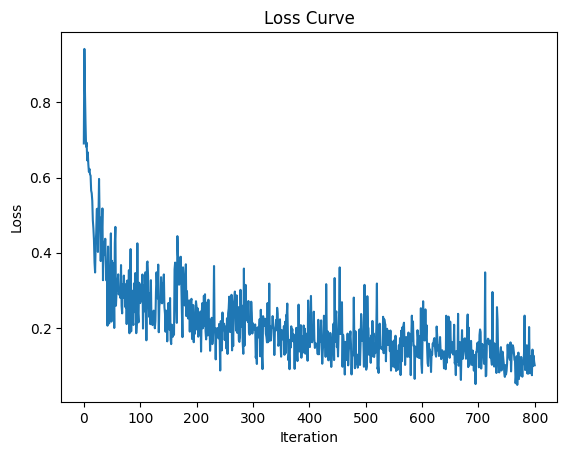

In [16]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

In [17]:
import mwatershed as mws

# Lets predict on some validation data:
val_raw, val_gt = datasplit.validate[0].raw, datasplit.validate[0].gt
# fetch a xy slice from the center of our validation volume
# We snap to grid to a multiple of the max downsampling factor of
# the unet (1, 8, 8) to ensure downsampling is always possible
roi = val_raw.roi
z_coord = Coordinate(1, 0, 0)
xy_coord = Coordinate(0, 1, 1)
center_offset = roi.center * z_coord + roi.offset * xy_coord + (roi.shape * xy_coord) // 4
center_size = val_raw.voxel_size * z_coord + (roi.shape * xy_coord) // 2
center_slice = Roi(center_offset, center_size)
center_slice = center_slice.snap_to_grid(val_raw.voxel_size * Coordinate(1, 8, 8))
context = (input_shape - output_shape) // 2 * val_raw.voxel_size

# Read the raw data
raw_input = val_raw.to_ndarray(center_slice.grow(context, context))

# Predict on the validation data
with torch.no_grad():
    device = torch.device("cpu")
    module = module.to(device)
    pred = (
        module(torch.from_numpy(raw_input).to(device).unsqueeze(0).unsqueeze(0))
        .cpu()
        .detach()
        .numpy()
    )

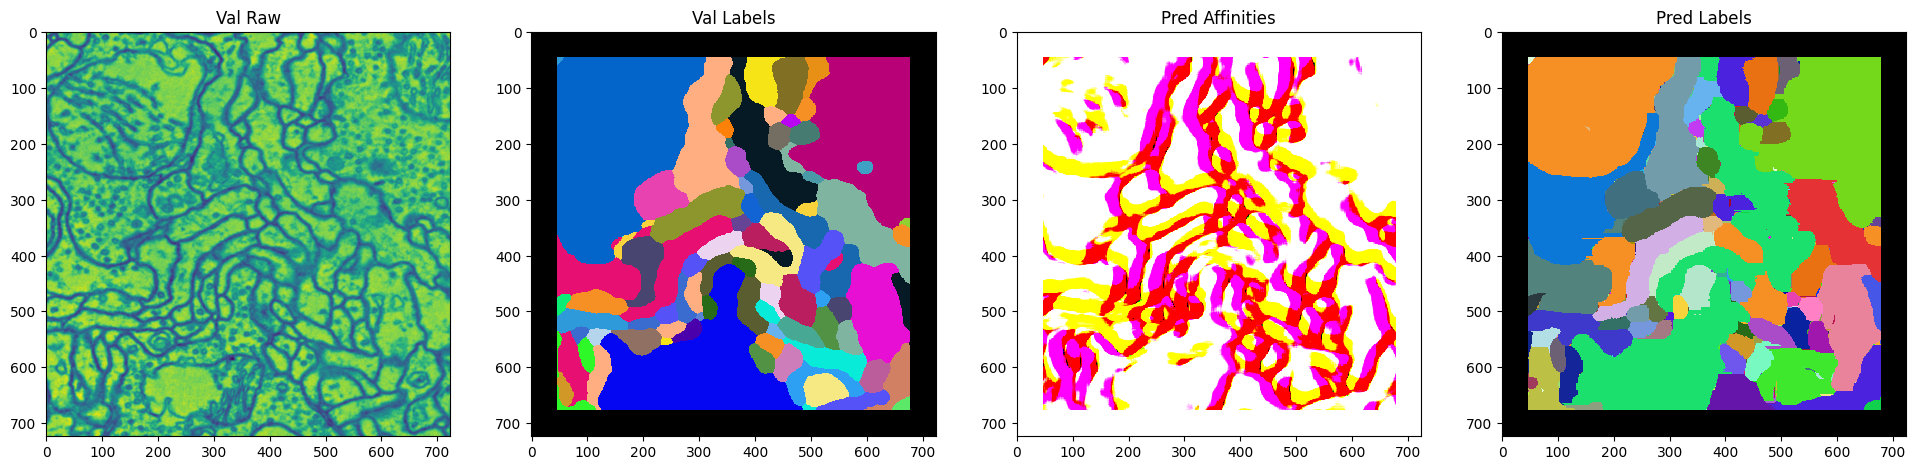

In [18]:
# Plot the results
fig, axes = plt.subplots(1, 4, figsize=(24, 8))
padding = (input_shape - output_shape) // 2

# select the long range affinity channels for visualization
prediction = pred[0, [0, 5, 6], 0]

# Run mutex watershed on the affinity predictions.
# We subtract 0.5 to move affs from range (0, 1) to (-0.5, 0.5).
# This is because mutex only splits objects on negative edges.
pred_labels = (
    mws.agglom(pred[0].astype(np.float64) - 0.5, offsets=affs_config.neighborhood)[0]
    % 256
)

# read the ground truth labels
gt_labels = val_gt.to_ndarray(center_slice)[0] % 256

# Pad
prediction = np.pad(
    prediction,
    ((0,), (padding[1],), (padding[2],)),
    mode="constant",
    constant_values=np.nan,
)
pred_labels = np.pad(
    pred_labels,
    ((padding[1],), (padding[2],)),
    mode="constant",
    constant_values=0,
)
gt_labels = np.pad(
    gt_labels,
    ((padding[1],), (padding[2],)),
    mode="constant",
    constant_values=0,
)

# Plot the results
im_raw = axes[0].imshow(raw_input[2])
im2 = axes[1].imshow(gt_labels, cmap=label_cmap, vmin=0, vmax=255, interpolation="none")
im4 = axes[2].imshow(prediction.transpose(1, 2, 0), interpolation="none")
im5 = axes[3].imshow(
    pred_labels, cmap=label_cmap, vmin=0, vmax=255, interpolation="none"
)
axes[0].set_title("Val Raw")
axes[1].set_title("Val Labels")
axes[2].set_title("Pred Affinities")
axes[3].set_title("Pred Labels")
plt.show()